In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from llm_deliberation.utils import bootstrap_statistic_df, change_of_minds

from pyprojroot import here
from mpl_lego.labels import bold_text, add_significance_bracket_inplot, apply_subplot_labels
from mpl_lego.style import use_latex_style

In [ ]:
use_latex_style()

In [ ]:
with open(here('data/analysis/exp1_sync_h2h.pkl'), 'rb') as file:
    exp1 = pickle.load(file)

with open(here('data/analysis/exp5_sync_h2h.pkl'), 'rb') as file:
    exp2 = pickle.load(file)

with open(here('data/analysis/exp6_sync_h2h.pkl'), 'rb') as file:
    exp3 = pickle.load(file)

In [ ]:
with open(here('data/analysis/exp8_sync_h2h.pkl'), 'rb') as file:
    gpt = pickle.load(file)

with open(here('data/analysis/exp7_sync_h2h.pkl'), 'rb') as file:
    claude = pickle.load(file)

with open(here('data/analysis/exp9_sync_h2h.pkl'), 'rb') as file:
    gemini = pickle.load(file)

In [ ]:
with open(here('data/analysis/exp1a_round_robin_h2h.pkl'), 'rb') as file:
    exp3b = pickle.load(file)

with open(here('data/analysis/exp1b_round_robin_h2h.pkl'), 'rb') as file:
    exp3a = pickle.load(file)

with open(here('data/analysis/exp2a_round_robin_h2h.pkl'), 'rb') as file:
    exp2a = pickle.load(file)

with open(here('data/analysis/exp2b_round_robin_h2h.pkl'), 'rb') as file:
    exp2b = pickle.load(file)

with open(here('data/analysis/exp3a_round_robin_h2h.pkl'), 'rb') as file:
    exp1b = pickle.load(file)

with open(here('data/analysis/exp3b_round_robin_h2h.pkl'), 'rb') as file:
    exp1a = pickle.load(file)

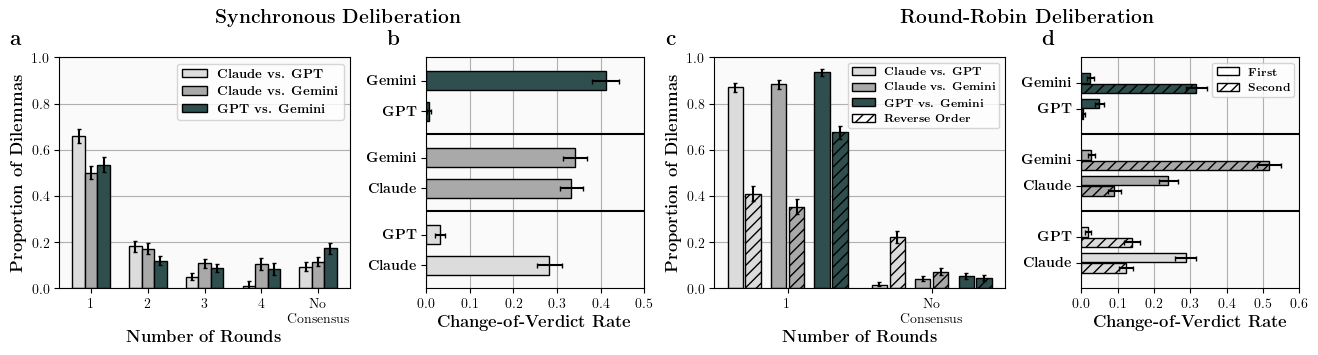

In [67]:
fig = plt.figure(figsize=(16, 3))

# Outer grid: two blocks; tweak outer_wspace only affects gap between the two blocks
outer = gridspec.GridSpec(
    nrows=1, ncols=2, width_ratios=[1, 1], wspace=0.12, hspace=0.0
)

# Left block
left = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[0], width_ratios=[1, 0.75], wspace=0.3
)
ax00 = fig.add_subplot(left[0, 0])
ax01 = fig.add_subplot(left[0, 1])

# Right block
right = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[1], width_ratios=[1, 0.75], wspace=0.3
)
ax10 = fig.add_subplot(right[0, 0])
ax11 = fig.add_subplot(right[0, 1])

# ---------------- LEFT BLOCK: Synchronous Deliberation ----------------
axes = [ax00, ax01]

dfs = [exp1, exp2, exp3]
colors = ['gainsboro', 'darkgray', 'darkslategray']
labels = bold_text(['Claude vs. GPT', 'Claude vs. Gemini', 'GPT vs. Gemini'])
n_rounds_range = [1, 2, 3, 4]
bar_width = 0.22
x = np.arange(len(n_rounds_range) + 1)

for i, df in enumerate(dfs):
    counts = df['n_rounds'].value_counts()
    counts[4] = counts.get(4, 0) - df['final_verdict'].isna().sum()
    counts = counts.reindex(n_rounds_range, fill_value=0)
    counts = counts / df.shape[0]

    no_consensus = df['final_verdict'].isna().sum() / df.shape[0]
    bar_heights = list(counts.values) + [no_consensus]

    lower_errs, upper_errs = [], []
    for round_val in n_rounds_range:
        boot = bootstrap_statistic_df(
            df=df,
            statistic_func=lambda x, rv=round_val: (x['n_rounds'] == rv).mean(),
            n_bootstrap=1000,
            confidence_level=0.95
        )
        lower_errs.append(boot['lower_err'])
        upper_errs.append(boot['upper_err'])

    boot_nc = bootstrap_statistic_df(
        df=df,
        statistic_func=lambda x: x['final_verdict'].isna().mean(),
        n_bootstrap=1000,
        confidence_level=0.95
    )
    lower_errs.append(boot_nc['lower_err'])
    upper_errs.append(boot_nc['upper_err'])

    yerr = np.array([lower_errs, upper_errs])

    axes[0].bar(
        x + (i - 1) * bar_width,
        bar_heights,
        width=bar_width,
        color=colors[i],
        edgecolor='black',
        label=labels[i],
        align='center',
        yerr=yerr,
        capsize=1.5)

axes[0].plot(1, (gpt['n_rounds'] == 1).mean(),    color='black', linewidth=2)
axes[0].plot(1, (claude['n_rounds'] == 1).mean(), color='black', linewidth=2)
axes[0].plot(1, (gemini['n_rounds'] == 1).mean(), color='black', linewidth=2)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y'); axes[0].set_axisbelow(True)
axes[0].tick_params(labelsize=10)
axes[0].set_xticks(x); axes[0].set_xticklabels(['1', '2', '3', '4', 'No\nConsensus'])
axes[0].set_xlabel(bold_text('Number of Rounds'), fontsize=12)
axes[0].set_ylabel(bold_text('Proportion of Dilemmas'), fontsize=12)
axes[0].legend(fontsize=9)

all_ticks = []
for idx, df in enumerate(dfs):
    ticks = [2 * idx - 0.4 + 1, 2 * idx + 0.4 + 1]
    w1 = change_of_minds(df['Agent_1_verdicts'], mean=True)
    w2 = change_of_minds(df['Agent_2_verdicts'], mean=True)

    boot1 = bootstrap_statistic_df(
        df=df,
        statistic_func=lambda x: change_of_minds(x['Agent_1_verdicts'], mean=True),
        n_bootstrap=1000,
        confidence_level=0.95
    )
    boot2 = bootstrap_statistic_df(
        df=df,
        statistic_func=lambda x: change_of_minds(x['Agent_2_verdicts'], mean=True),
        n_bootstrap=1000,
        confidence_level=0.95
    )
    xerr = np.array([
        [boot1['lower_err'], boot2['lower_err']],
        [boot1['upper_err'], boot2['upper_err']]
    ])

    axes[1].barh(
        y=ticks,
        width=[w1, w2],
        height=0.5,
        color=colors[idx],
        edgecolor='black',
        xerr=xerr,
        error_kw={'capsize': 1.8}
    )
    all_ticks.extend(ticks)

axes[1].axhline(2, linestyle='-', color='black')
axes[1].axhline(4, linestyle='-', color='black')
axes[1].set_xlim([0, 0.5])
axes[1].set_ylim([0, 6])
axes[1].set_yticks(all_ticks)
axes[1].set_yticklabels(bold_text(['Claude', 'GPT', 'Claude', 'Gemini', 'GPT', 'Gemini']))
axes[1].grid(axis='x'); axes[1].set_axisbelow(True)
axes[1].set_xlabel(bold_text('Change-of-Verdict Rate'), fontsize=12)

for ax in axes:
    ax.set_facecolor('0.98')

apply_subplot_labels(axes, bold=True, y=1.08)

# ---------------- RIGHT BLOCK: Round-Robin Deliberation ----------------
axes = [ax10, ax11]

dfs   = [exp1a, exp1b, exp2a, exp2b, exp3a, exp3b]
pairs = [('Claude', 'GPT'), ('Claude', 'Gemini'), ('GPT', 'Gemini')]

colors  = ['gainsboro', 'darkgray', 'darkslategray']
hatch_B = '///'
cats = ['1', 'No\nConsensus']

bar_width = 0.18
ab_gap    = 0.03
group_gap = 0.12
num_groups = len(pairs)

def group_offset(gidx, is_B):
    within = 1 if is_B else 0
    group_center = (gidx - (num_groups - 1)/2) * (2*bar_width + ab_gap + group_gap)
    within_offset = (within - 0.5) * (bar_width + ab_gap)
    return group_center + within_offset

max_group_span = ((num_groups - 1)/2) * (2*bar_width + ab_gap + group_gap)
max_within     = 0.5 * (bar_width + ab_gap)
max_offset     = max_group_span + max_within
sep            = 1.2 * (max_offset + bar_width/2)

x = np.array([-sep, +sep])

for j, df in enumerate(dfs):
    g = j // 2
    is_B = (j % 2 == 1)
    offset = group_offset(g, is_B)

    p1  = (df['n_rounds'] == 1).mean()
    pnc = df['final_verdict'].isna().mean()
    bars = [p1, pnc]

    boot1 = bootstrap_statistic_df(
        df=df,
        statistic_func=lambda x: (x['n_rounds'] == 1).mean(),
        n_bootstrap=1000, confidence_level=0.95)
    bootN = bootstrap_statistic_df(
        df=df,
        statistic_func=lambda x: x['final_verdict'].isna().mean(),
        n_bootstrap=1000, confidence_level=0.95)

    yerr = np.array([
        [boot1['lower_err'], bootN['lower_err']],
        [boot1['upper_err'], bootN['upper_err']]
    ])

    axes[0].bar(
        x + offset, bars,
        width=bar_width,
        color=colors[g],
        edgecolor='black',
        hatch=(hatch_B if is_B else None),
        align='center',
        yerr=yerr, capsize=1.5
    )

axes[0].set_ylim([0, 1])
axes[0].grid(axis='y'); axes[0].set_axisbelow(True)
axes[0].tick_params(labelsize=10)
axes[0].set_xticks(x); axes[0].set_xticklabels(cats)
axes[0].set_xlabel(bold_text('Number of Rounds'), fontsize=12)
axes[0].set_ylabel(bold_text('Proportion of Dilemmas'), fontsize=12)

axes[0].legend(
    handles=[
        Patch(facecolor='gainsboro', edgecolor='black', label=bold_text('Claude vs. GPT')),
        Patch(facecolor='darkgray', edgecolor='black', label=bold_text('Claude vs. Gemini')),
        Patch(facecolor='darkslategray', edgecolor='black', label=bold_text('GPT vs. Gemini')),
        Patch(facecolor='white', edgecolor='black', hatch=hatch_B, label=bold_text('Reverse Order'))],
    fontsize=8, frameon=True, loc='upper right'
)

pair_height = 0.36
dy = pair_height/2 + 0.02

yticks_centers = []
ytick_labels_plain = []

for m, (a, b) in enumerate(pairs):
    color = colors[m]
    df_A, df_B = dfs[2 * m], dfs[2 * m + 1]

    y_a = 3 * m + 1
    y_b = 3 * m + 2

    w_a_A = change_of_minds(df_A['Agent_1_verdicts'], mean=True)
    w_a_B = change_of_minds(df_B['Agent_2_verdicts'], mean=True)
    boot_a_A = bootstrap_statistic_df(
        df=df_A,
        statistic_func=lambda x: change_of_minds(x['Agent_1_verdicts'], mean=True),
        n_bootstrap=1000, confidence_level=0.95)
    boot_a_B = bootstrap_statistic_df(
        df=df_B,
        statistic_func=lambda x: change_of_minds(x['Agent_2_verdicts'], mean=True),
        n_bootstrap=1000, confidence_level=0.95)

    axes[1].barh(y=y_a - dy, width=w_a_A, height=pair_height,
                 color=color, edgecolor='black', hatch=hatch_B)
    axes[1].errorbar(x=w_a_A, y=y_a - dy,
                     xerr=[[boot_a_A['lower_err']], [boot_a_A['upper_err']]],
                     fmt='none', capsize=1.8, ecolor='black')
    axes[1].barh(y=y_a + dy, width=w_a_B, height=pair_height,
                 color=color, edgecolor='black')
    axes[1].errorbar(x=w_a_B, y=y_a + dy,
                     xerr=[[boot_a_B['lower_err']], [boot_a_B['upper_err']]],
                     fmt='none', capsize=1.8, ecolor='black')

    w_b_A = change_of_minds(df_A['Agent_2_verdicts'], mean=True)
    w_b_B = change_of_minds(df_B['Agent_1_verdicts'], mean=True)
    boot_b_A = bootstrap_statistic_df(
        df=df_A,
        statistic_func=lambda x: change_of_minds(x['Agent_2_verdicts'], mean=True),
        n_bootstrap=1000, confidence_level=0.95)
    boot_b_B = bootstrap_statistic_df(
        df=df_B,
        statistic_func=lambda x: change_of_minds(x['Agent_1_verdicts'], mean=True),
        n_bootstrap=1000, confidence_level=0.95)

    axes[1].barh(y=y_b - dy, width=w_b_B, height=pair_height,
                 color=color, edgecolor='black', hatch=hatch_B)
    axes[1].errorbar(x=w_b_B, y=y_b - dy,
                     xerr=[[boot_b_B['lower_err']], [boot_b_B['upper_err']]],
                     fmt='none', capsize=1.8, ecolor='black')
    axes[1].barh(y=y_b + dy, width=w_b_A, height=pair_height,
                 color=color, edgecolor='black')
    axes[1].errorbar(x=w_b_A, y=y_b + dy,
                     xerr=[[boot_b_A['lower_err']], [boot_b_A['upper_err']]],
                     fmt='none', capsize=1.8, ecolor='black')

    yticks_centers.extend([y_a, y_b])
    ytick_labels_plain.extend([a, b])

axes[1].axhline(3, linestyle='-', color='black')
axes[1].axhline(6, linestyle='-', color='black')
axes[1].set_xlim([0, 0.6])
axes[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
axes[1].set_ylim([0, 9])
axes[1].set_yticks(yticks_centers)
axes[1].set_yticklabels(bold_text(ytick_labels_plain))
axes[1].grid(axis='x'); axes[1].set_axisbelow(True)
axes[1].set_xlabel(bold_text('Change-of-Verdict Rate'), fontsize=12)

axes[1].legend(
    handles=[
        Patch(facecolor='white', edgecolor='black', label=bold_text('First')),
        Patch(facecolor='white', edgecolor='black', hatch=hatch_B, label=bold_text('Second'))],
    fontsize=8, frameon=True, loc='upper right'
)

for ax in axes:
    ax.set_facecolor('0.98')

apply_subplot_labels(axes, bold=True, y=1.08, labels=['c', 'd'])
fig.text(0.30, 1.04, bold_text('Synchronous Deliberation'), ha='center', va='top', fontsize=14)
fig.text(0.73, 1.04, bold_text('Round-Robin Deliberation'), ha='center', va='top', fontsize=14)

plt.savefig('figure_delib_outcomes.pdf', bbox_inches='tight')